In [0]:
##Necessary imports
import numpy as np
import cv2 as cv
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

In [0]:
##Time to load the dataset
##getting the files
##Loading the image files from the google drive
##importing google colab essentials:--
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
##Authentication

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

    100% |████████████████████████████████| 993kB 19.8MB/s 


In [0]:
file_id = "1nwjwaCI74fx2QutmZFnr1e4YzYlW2dFe"
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('train.zip')

In [0]:
##unzipping the dataset
!unzip train.zip

In [0]:
##looking at the files
!ls 

adc.json  sample_data  Train  train.csv  train.zip


In [0]:
##loading train.csv
csv_file = pd.read_csv("train.csv")
csv_file.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


Age:-> MIDDLE
Age:-> YOUNG
Age:-> MIDDLE
Age:-> YOUNG
Age:-> MIDDLE
Age:-> MIDDLE
Age:-> YOUNG
Age:-> YOUNG
Age:-> YOUNG


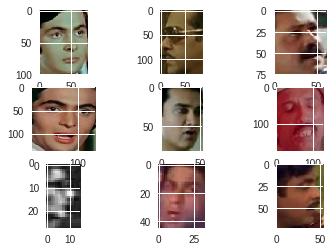

In [0]:
##Lets analyse the shapes of the images
from scipy.misc import imresize,imread
import os
for i in range(9):
  k = np.random.choice(csv_file.index)
  img_name = csv_file.ID[k]
  ##displaying the image
  plt.subplot(331+i)
  img = imread(os.path.join('Train',img_name))
  print('Age:->',csv_file.Class[i])
  plt.imshow(img)
  
##Thus it can be noticed that images are not of constant shape

In [0]:
##inspecting the labels
csv_file['Class'].value_counts()

MIDDLE    10804
YOUNG      6706
OLD        2396
Name: Class, dtype: int64

In [0]:
##getting the images
##Getting the training dataset
##we are going to reshape the image to 32,32,3
import os
temp = []
for img_name in csv_file.ID:
    img_path = os.path.join('Train', img_name)
    img = imread(img_path)
    img = imresize(img, (32, 32))
    img = img.astype('float32') # this will help us in later stage
    temp.append(img)

train_images = np.stack(temp)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


#Stage-1 (Clustering)

In [0]:
##Necessary imports 
from sklearn.preprocessing import StandardScaler
from matplotlib.offsetbox import OffsetImage,AnnotationBbox
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [0]:
def visualize_scatter_with_images(x_2d_data,images,figsize = (45,45),image_zoom = 1):
  
  fig,ax = plt.subplots(figsize = figsize)
  artists = []
  for xy,i in zip(x_2d_data,images):
    x0,y0 = xy
    img = OffsetImage(i,zoom_range = image_zoom)
    ab = AnnotationBbox(img,(x0,y0),xycoords = 'data',
                       frameon = False)
    artists.append(ax.add_artists(ab))
  ax.update_datalim(x_2d_data)
  
  
def visualize_scatter(data_2d,label_ids,figsize = (16,16)):
  plt.figure(figsize = figsize)
  plt.grid()
  nb_classes = len(np.unique(label_ids))
  for label_id in np.unique(label_ids):
    plt.scatter(data_2d[np.where(label_ids == label_id),0],
               data_2d[np.where(label_ids == label_id),1],
               marker= 'o',
               color = plt.cm.Set1(label_id/float(nb_classes)),
               linewidth = '1',
               alpha = 0.9,
               label = id_to_label_dict[label_id])
    plt.legend(loc= 'best')

flat_images = []
for i in train_images:
  img = img.flatten()
  flat_images.append(img)
  
flat_images = np.array(flat_images)


label_to_id_dict = {v:i for i,v in enumerate(np.unique(csv_file['Class']))}
id_to_label_dict = {v:k for k,v in label_to_id_dict.items()}
label_ids = np.array([label_to_id_dict[x] for x in csv_file['Class']])
image_scaled  = StandardScaler().fit_transform(flat_images)

##Fitting the PCA
pca = PCA(n_components = 10)
pca_result = pca.fit_transform(image_scaled)


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/pca.py:535: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()


In [0]:
##Applying TSNE
tsne = TSNE(n_components = 2,perplexity = 40.0)
tsne_result = tsne.fit_transform(pca_result)
tsne_scaled = StandardScaler().fit_transform(tsne_result)

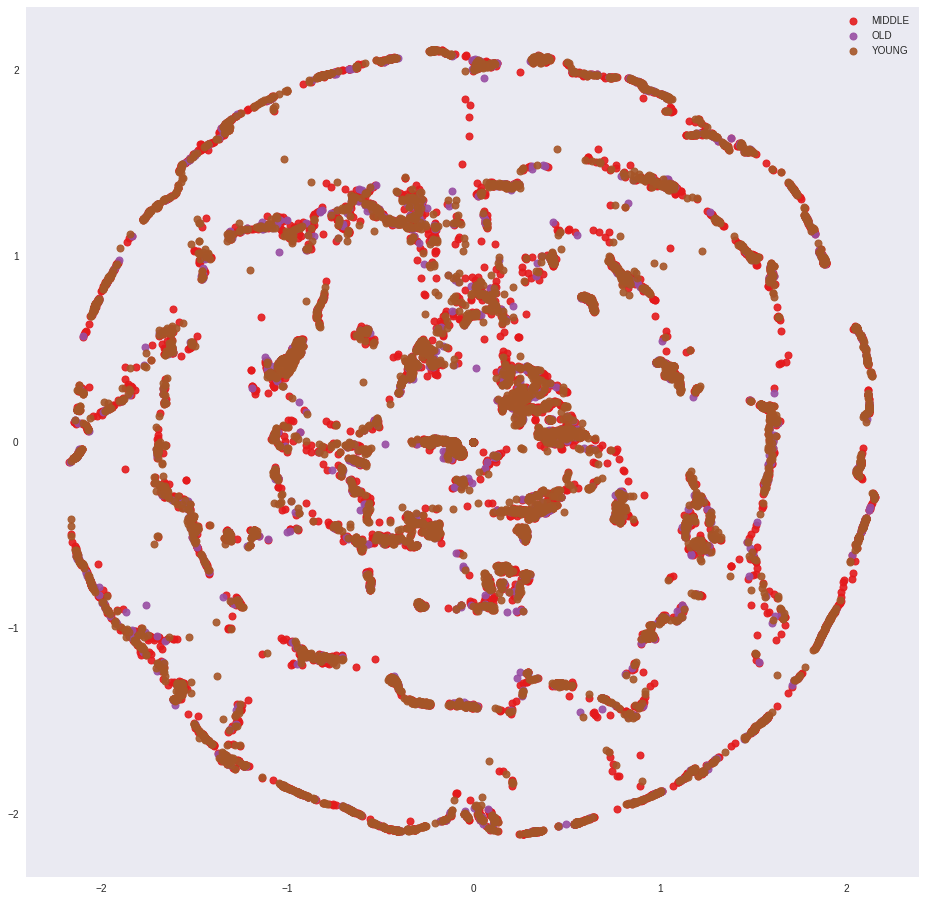

In [0]:
##Visualization
visualize_scatter(tsne_scaled,label_ids)

##Hence its a difficult classification task.

#Feature Extraction using Pretrained Models  


In [0]:
##Necessary imports 
import keras

##Importing pretrained models from keras.applications
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.applications.xception import Xception, preprocess_input
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import image
from keras.models import Model
from keras.models import model_from_json
from keras.layers import Input

Using TensorFlow backend.


In [0]:
##Defining Feature Extractor
##Defining a function to do Fetaure Extraction
def extract_features(model_name,weights = "imagenet",include_top = False):
  """
  This function different models to perform feature extraction based on the feautres learned through ImageNet dataset.
  Arguments:--
  model_name:  string
                It should be one of pretrained models of keras.applications.
  weights:  string
            default is imagenet.
  include_top:  boolean
                default = False
                
  returns keras model of type Model.
                
  """
  
  ##Model name VGG16
  if model_name == 'vgg16':
    base_model = VGG16(weights = weights)
    model = Model(input = base_model.input,
                 output = base_model.get_layer('fc1').output)
    
  elif model_name == 'vgg19':
    base_model = VGG19(weights = weights)
    model = Model(input = base_model.input,
                 output = base_model.get_layer('fc1').output)
    
  elif model_name == "inceptionv3":
    base_model = InceptionV3(include_top = include_top,weights = weights,
                            input_tensor = Input(shape = (299,299,3)))
    model = Model(input = base_model.input,output = base_model.get_layer('custom').output)
    
  elif model_name == "resnet50":
    base_model = ResNet50(weights=weights)
    model = Model(input=base_model.input, output=base_model.get_layer('flatten').output)
    
    
  elif model_name == "inception_resnetv2":
    base_model = InceptionResNetV2(include_top = include_top,weights = weights,
                            input_tensor = Input(shape = (299,299,3)))
    model = Model(input = base_model.input,output = base_model.get_layer('custom').output)
   
    
  elif model_name == "mobilenet":
    base_model = MobileNet(include_top  =include_top,weights = weights,
                          input_tensor = Input(shape = (224,224,3)))
    model = Model(input = base_model.input,output = base_model.get_layer('conv_pw_13_bn').output)
    
  elif model_name == "xception":
    base_model = Xception(weights = weights)
    model = Model(input = base_model.input,
                 output = base_model.get_layer('avg_pool').output)
    
  else:
    base_model = None
    
  return model



In [0]:
##Defining the input_size parameters for all the models
image_size = {"vgg16":(224,224),
             "vgg19":(224,224),
             "inceptionv3":(299,299),
             "inception_resnetv2":(299,299),
             "mobilenet":(224,224),
             "xception":(299,299),
             "resnet50":(224,224)}

In [0]:
def generate_features(image_size,nb_images,model,data):
  """
  This function returns the generated features
  Arguments:-
  image_size = tuple
  nb_images = no of images in the training data
  model = string name of the model
  """
  
  features = []
  for i in range(nb_images):
    x = data[i]
    x = imresize(x,image_size)
    x = np.expand_dims(x,axis = 0)
    ##scalling the image
    x = x/255.0
    x = preprocess_input(x)
    pred = model.predict(x)
    if i % 10000 == 0:
      print("Feature Extraction For Image {} has been done".format(i+1))
    pred = pred.flatten()
    features.append(pred)
    
  return features



In [0]:
##Calling the extractor for vgg16
model_vgg16 = extract_features(model_name = "vgg16",weights = "imagenet",include_top = False)
##Calling the generator
features_vgg16 = generate_features(image_size = image_size['vgg16'],nb_images = len(train_images),model = model_vgg16,data = train_images)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("fc...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  del sys.path[0]


Feature Extraction For Image 1 has been done
Feature Extraction For Image 10001 has been done


In [0]:
##Calling the extractor for vgg19
#model_vgg19 = extract_features(model_name = "vgg19",weights = "imagenet",include_top = False)
##Calling the generator
#features_vgg19 = generate_features(image_size = image_size['vgg19'],nb_images = len(train_images),model = model_vgg19,data = train_images)

##Calling the extractor for xception
#model_xception = extract_features(model_name = "xception",weights = "imagenet",include_top = False)
##Calling the generator
#features_xception = generate_features(image_size = image_size['xception'],nb_images = len(train_images),model = model_xception,data = train_images)

##Calling the extractor for inception
#model_inception = extract_features(model_name = "inceptionv3",weights = "imagenet",include_top = False)
##Calling the generator
#features_inception = generate_features(image_size = image_size['inceptionv3'],nb_images = len(train_images),model = model_inception,data = train_images)

##Calling the extractor for resnet50
#model_resnet = extract_features(model_name = "resnet50",weights = "imagenet",include_top = False)
##Calling the generator
#features_resnet = generate_features(image_size = image_size['resnet50'],nb_images = len(train_images),model = model_resnet50,data = train_images)

##Calling the extractor for mobilenet
model_mobilenet = extract_features(model_name = "mobilenet",weights = "imagenet",include_top = False)
##Calling the generator
features_mobilenet = generate_features(image_size = image_size['mobilenet'],nb_images = len(train_images),model = model_mobilenet,data = train_images)

##Calling the extractor for inception_resnetv2
#model_ires = extract_features(model_name = "inception_resnetv2",weights = "imagenet",include_top = False)
##Calling the generator
#features_ires = generate_features(image_size = image_size['inception_resnetv2'],nb_images = len(train_images),model = model_ires,data = train_images)

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:208: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  del sys.path[0]


Feature Extraction For Image 1 has been done
Feature Extraction For Image 10001 has been done


In [0]:
##unsig label encoder to encode the target variables
target = csv_file['Class'].map({"MIDDLE":5,"YOUNG":0,"OLD":10})
target.ndim

1

In [0]:
## We will use one vs rest classifier for prediction task
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

all_model_score = dict()

def data_splitter(feature_name,y):
  X_train,X_test,y_train,y_test = train_test_split(feature_name,y,stratify = y,random_state = 42)
  return X_train,X_test,y_train,y_test
def predictor(feature_name,y,model_name):
  X_train,X_test,y_train,y_test = data_splitter(feature_name,y)
  lr = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')
  fitter = lr.fit(X_train,y_train)
  pred = fitter.predict(X_test)
  
  score = accuracy_score(y_test,pred)
  all_model_score[model_name] = score
  print("accuracy is {}".format(score))
  

In [0]:
##Running prediction task
for name in model_names:
  
predictor(feature_name = np.array(features_mobilenet),y = target,model_name = "mobilenet")

In [0]:
all_model_score

{'vgg16': 0.5426964034558971, 'xception': 0.595539481615431}

#Fine Tuning PreTrained Models

In [0]:
##necessary keras imports
from keras.models import Sequential,Model
from keras.layers import Flatten,Dense,Dropout
from keras.optimizers import Adam
from keras import backend as K
from keras import applications

In [0]:
##Clearning the session
K.clear_session()

In [0]:
# Number of epochs
epochs = 3

# Batchsize
batch_size = 128

# Optimizer for the model
optimizer = Adam(lr=0.0001, beta_1=0.5)

# Shape of the input image
input_shape = (224, 224, 3)

# Batch interval at which loss is to be stores
store = 40 

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
# load the vgg16 model 
model = applications.vgg19.VGG19(weights = "imagenet", include_top=False, input_shape = input_shape)

# print summary of vgg16 model
model.summary()

80142336/80134624 [==============================] - 19s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_poo

In [0]:
model.layers[:-4]

In [0]:
# set layers as non trainable
for layer in model.layers[:-4]:
    layer.trainable = False


In [0]:
# Adding custom Layers
x = model.output
x = Flatten()(x)
x = Dense(512, activation="relu")(x)

# Dense layer with 14 neurons for predicting 14 numeric values
predictions = Dense(3, activation="softmax")(x)

In [0]:
# creating the final model 
model_final = Model(inputs = model.input, outputs = predictions)

# print summary
model_final.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizer)

In [0]:
import PIL
from PIL import Image
import os
import sys
def readf():  
  try:
    
    input_dir  = 'Train'  #path to img source folder
    img_size   = 224  #The image size (128, 256,etc)
    output_imgs = [] #output directory
      #print "starting...."
       #   print "Colecting data from %s " % input_dir
    tclass = [ d for d in csv_file.ID ]
    counter = 0
    for x in tclass:    

      img = Image.open(os.path.join(input_dir+'/'+x))
      img = img.resize((int(img_size),int(img_size)),Image.ANTIALIAS)
      img = np.array(img)
      output_imgs.append(img)
      counter +=1
  except IsADirectoryError:
    pass
  
  return output_imgs
images = readf()

In [0]:
##converting images to array
images = np.array(images)
images.shape

(19906, 224, 224, 3)

In [0]:
##Creating the label
from keras.utils import to_categorical
csv_file['int_cl'] = csv_file['Class'].map({'MIDDLE':1,'YOUNG':0,'OLD':2})
y = csv_file['int_cl'].values
y = to_categorical(y)
y.shape

Using TensorFlow backend.


(19906, 3)

In [0]:
history = model_final.fit(images,y,batch_size = batch_size,epochs = 3,validation_split =0.09)

In [0]:
model_final.predict(test)

In [0]:
test = images[:100].reshape(-1,224,224,3)

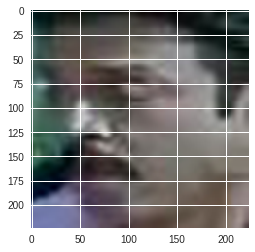

In [0]:
plt.imshow(images[556])